### Import Packages

In [61]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

### Helper functions

In [62]:
def Performance_ROC(Model,Y,X,loc):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)#%% md
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')#%%
    plt.legend(loc="lower right")
    plt.savefig(loc)
    plt.show()

In [63]:
def Performance_ROC_multi(ModelA,ModelB,Y,X, loc):
     fpr, tpr, _ = roc_curve(Y, ModelA.predict_proba(X)[:,1])
     AUC  = round(auc(fpr, tpr),5)
     print('the AUC of the model before HyperOpt is : %0.4f' %  AUC)
     plt.plot(fpr,tpr,label="Model before HyperOpt, auc="+str(AUC))

     fpr, tpr, _ = roc_curve(Y, ModelB.predict_proba(X)[:,1])
     AUC  = round(auc(fpr, tpr),5)
     print('the AUC of the model after HyperOpt is : %0.4f' %  AUC)
     plt.plot(fpr,tpr,label="Model after HyperOpt, auc="+str(AUC))

     plt.plot([0, 1], [0, 1], 'k--')
     plt.xlim([0.0, 1.0])
     plt.ylim([0.0, 1.05])
     plt.xlabel('False Positive Rate')
     plt.ylabel('True Positive Rate')
     plt.title('ROC Curve')#%%
     plt.legend(loc="lower right")
     plt.savefig(loc)
     plt.show()

In [64]:
def Performance_conf(Model,X,Y,loc):
    plot_confusion_matrix(Model,X,Y)
    plt.savefig(loc)
    plt.show()


In [65]:
def Performance_scores(Model,X,Y):
    predicts = Model.predict(X)
    accuracy = accuracy_score(Y, predicts)
    f1 = f1_score(Y,predicts)
    print('Accuracy; ', round(accuracy*100,2) , '%')
    print('F1 score: ',round(f1*100,2) , '%')

### Import Data

In [66]:
data = pd.read_csv('data_issold.csv')
# remove access column
data =data.drop('increment_type_nl Biedrange 0-15 1 euro (Beuknoot)', axis = 1)

<AxesSubplot:>

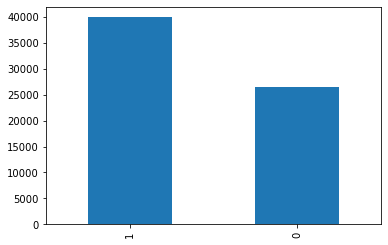

In [67]:
# Check for whether labels are imbalanced
data['is_sold'].value_counts().plot(kind='bar')

In [68]:
# show head
data.head()

,auction_fee_tax_rate,is_1euro_kavel,is_sold,start_amount,bidding_window,is_homedelivery,is_public,is_automatic_credit,category_Accu-/ elektrisch gereedschap,category_Auto-onderdelen en accessoires,...,Day_3,Day_4,Day_5,Day_6,Month_1,Month_2,Month_3,increment_standard,increment_1euro,increment_other
0,21,0,0,65.0,9360.0,1.0,1.0,0.0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,21,0,0,335.0,7920.0,1.0,1.0,0.0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,21,0,0,65.0,7920.0,1.0,1.0,0.0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,21,1,0,1.0,2220.0,1.0,0.0,1.0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,21,1,1,1.0,2160.0,1.0,0.0,1.0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [69]:
#show shape
data.shape

(66271, 43)

In [70]:
#show list of columns
list(data.columns)

['auction_fee_tax_rate',
 'is_1euro_kavel',
 'is_sold',
 'start_amount',
 'bidding_window',
 'is_homedelivery',
 'is_public',
 'is_automatic_credit',
 'category_Accu-/ elektrisch gereedschap',
 'category_Auto-onderdelen en accessoires',
 'category_Computers en Software',
 'category_Dameskleding en -schoenen',
 'category_Herenkleding en -schoenen',
 'category_Horloges',
 'category_Kantoorinrichting',
 'category_Other',
 'category_Sanitair',
 'category_Sieraden',
 'category_Slapen',
 'category_Tuin en terras',
 'category_Unisex',
 'category_Verlichting',
 'category_Woninginrichting',
 'condition_New',
 'condition_Old',
 'seller_type_New Seller',
 'seller_type_Seller',
 'sourcing_company_3rdpartydailyspecials',
 'sourcing_company_art',
 'sourcing_company_bva',
 'Day_0',
 'Day_1',
 'Day_2',
 'Day_3',
 'Day_4',
 'Day_5',
 'Day_6',
 'Month_1',
 'Month_2',
 'Month_3',
 'increment_standard',
 'increment_1euro',
 'increment_other']

### Split Data 20% split

In [71]:
# Labels are the values we want to predict
labels = data['is_sold']
# Remove the labels from the features
features= data.drop('is_sold', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
# features = np.array(features)

In [72]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

print('The shape of our data is:', data.shape)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

The shape of our data is: (66271, 43)
Training Features Shape: (53016, 42)
Training Labels Shape: (53016,)
Testing Features Shape: (13255, 42)
Testing Labels Shape: (13255,)


### Standerdize data using StandardScaler

In [73]:
# standardize the feature variables
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)
# test_features = scaler.fit_transform(test_features)

### Random Forest without hyper parameter optimisation

In [74]:
RF0=RandomForestClassifier()
RF0.fit(train_features, train_labels)

RandomForestClassifier()

In [75]:
# General performance scores
Performance_scores(Model=RF0,Y=test_labels,X=test_features)

Accuracy;  88.69 %
F1 score:  90.76 %


the AUC is : 0.9190


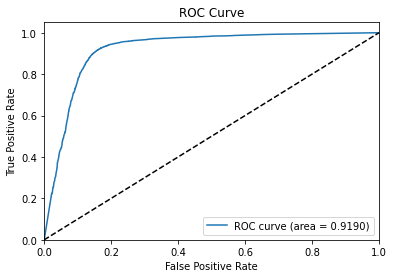

In [76]:
# ROC curve
Performance_ROC(Model=RF0,Y=test_labels,X=test_features,loc='Random Forest/ROC_base_model.png')

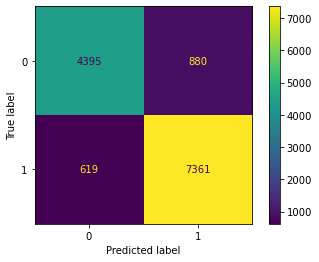

In [77]:
# Confusion matrix
Performance_conf(Model=RF0,Y=test_labels,X=test_features,loc='Random Forest/CM_base_model.png')

### Random Forest using Hyperopt

In [18]:
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, test_features, test_labels).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,42)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1,15)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best)

new best:                                                                                                              
0.8828366654092796                                                                                                     
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 36, 'min_samples_leaf': 4, 'n_estimators': 233}              
new best:                                                                                                              
0.8828366654092796                                                                                                     
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 24, 'min_samples_leaf': 9, 'n_estimators': 264}              
new best:                                                                                                              
0.8828366654092796                                                                                                     
{'criterion': 'entropy', 'max_depth': 12

0.8854771784232366                                                                                                     
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 33, 'min_samples_leaf': 3, 'n_estimators': 101}              
new best:                                                                                                              
0.8854771784232366                                                                                                     
{'criterion': 'gini', 'max_depth': 15, 'max_features': 14, 'min_samples_leaf': 10, 'n_estimators': 499}                
new best:                                                                                                              
0.8854771784232366                                                                                                     
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 11, 'n_estimators': 294}               
new best:                               

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 374}                
new best:                                                                                                              
0.8855526216522067                                                                                                     
{'criterion': 'entropy', 'max_depth': 18, 'max_features': 38, 'min_samples_leaf': 1, 'n_estimators': 181}              
new best:                                                                                                              
0.8855526216522067                                                                                                     
{'criterion': 'gini', 'max_depth': 16, 'max_features': 14, 'min_samples_leaf': 8, 'n_estimators': 173}                 
new best:                                                                                                              
0.8855526216522067                      

In [78]:
RF2=RandomForestClassifier(max_features=35,
                           n_estimators=260,
                           criterion= 'entropy',
                           max_depth=18,
                           min_samples_leaf=3,
                           random_state=42)
RF2.fit(train_features, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=18, max_features=35,
                       min_samples_leaf=3, n_estimators=260, random_state=42)

In [79]:
# After Hyperopt performance scores
Performance_scores(Model=RF2,Y=test_labels,X=test_features)

Accuracy;  89.44 %
F1 score:  91.41 %


the AUC is : 0.9245


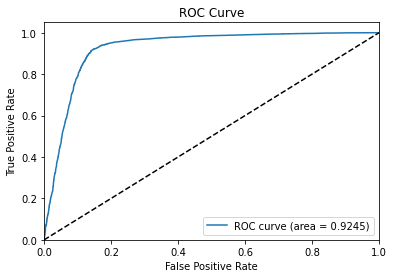

In [80]:
# ROC curve
Performance_ROC(Model=RF2,Y=test_labels,X=test_features,loc='Random Forest/ROC_hypopt_model.png')

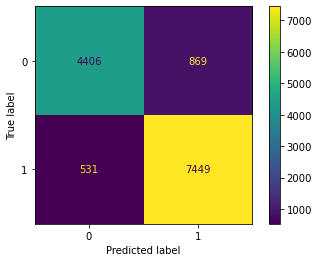

In [81]:
# Confusion matrix
Performance_conf(Model=RF2,Y=test_labels,X=test_features,loc='Random Forest/CM_hypopt_model.png')

In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,plot_confusion_matrix
acc = accuracy_score(test_labels, RF2.predict(test_features))
prec = precision_score(test_labels, RF2.predict(test_features))
rec = recall_score(test_labels, RF2.predict(test_features))
f1 = f1_score(test_labels, RF2.predict(test_features))
roc = roc_auc_score(test_labels, RF2.predict(test_features))
print("The accuracy on test set: {:.4f}".format(acc))
print("The precision on test set: {:.4f}".format(prec))
print("The recall on test set: {:.4f}".format(rec))
print("The F1 score on test set: {:.4f}".format(f1))
print("The ROC AUC score on test set: {:.4f}".format(roc))

The accuracy on test set: 0.8944
The precision on test set: 0.8955
The recall on test set: 0.9335
The F1 score on test set: 0.9141
The ROC AUC score on test set: 0.8844


the AUC of the model before HyperOpt is : 0.9188
the AUC of the model after HyperOpt is : 0.9244


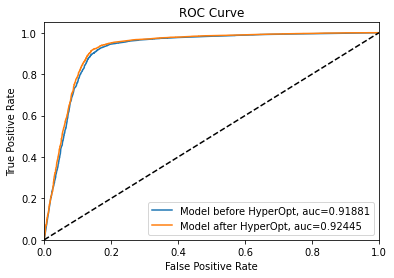

In [53]:
# plot difference between models ROC
Performance_ROC_multi(ModelA=RF0,
                      ModelB=RF2,
                      Y=test_labels,
                      X=test_features,
                      loc='Random Forest/ROC_multi.png')



### Feature importance

In [54]:
# Get numerical feature importances
importances = list(RF2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: start_amount         Importance: 0.47
Variable: bidding_window       Importance: 0.26
Variable: is_1euro_kavel       Importance: 0.04
Variable: Day_5                Importance: 0.02
Variable: Day_6                Importance: 0.02
Variable: increment_1euro      Importance: 0.02
Variable: auction_fee_tax_rate Importance: 0.01
Variable: is_homedelivery      Importance: 0.01
Variable: is_public            Importance: 0.01
Variable: is_automatic_credit  Importance: 0.01
Variable: category_Other       Importance: 0.01
Variable: category_Sanitair    Importance: 0.01
Variable: category_Verlichting Importance: 0.01
Variable: category_Woninginrichting Importance: 0.01
Variable: Day_0                Importance: 0.01
Variable: Day_1                Importance: 0.01
Variable: Day_2                Importance: 0.01
Variable: Day_3                Importance: 0.01
Variable: Day_4                Importance: 0.01
Variable: Month_1              Importance: 0.01
Variable: Month_2              Impo

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

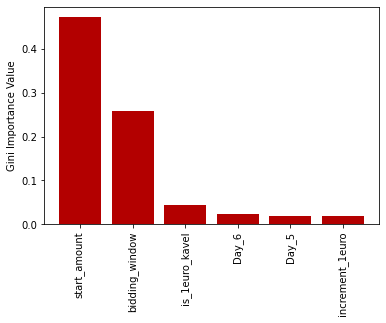

In [55]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(feature_list),
                   'importance': RF2.feature_importances_}).\
                    sort_values('importance', ascending = False)

plt.figure()

plt.bar(fi.iloc[:6 , 0], fi.iloc[:6, 1],color=(0.7,0,0,1))
plt.ylabel("Gini Importance Value")
plt.xticks(rotation=90)
plt.savefig('Random Forest/Feature importance.png',bbox_inches='tight')
plt.show()


In [56]:
data2 = data[['is_sold',
              'start_amount',
              'bidding_window',
              'Day_5',
              'is_1euro_kavel',
              'Day_6',
              'increment_1euro']]
data2

,is_sold,start_amount,bidding_window,Day_5,is_1euro_kavel,Day_6,increment_1euro
0,0,65.0,9360.0,0,0,0,0
1,0,335.0,7920.0,0,0,0,0
2,0,65.0,7920.0,0,0,0,0
3,0,1.0,2220.0,0,1,0,1
4,1,1.0,2160.0,0,1,0,1
...,...,...,...,...,...,...,...
66266,1,1.0,2160.0,0,1,0,1
66267,1,1.0,2220.0,0,1,0,1
66268,0,1.0,2040.0,0,1,0,1
66269,0,5.0,15540.0,0,0,0,0


In [57]:
# Labels are the values we want to predict
labels = data2['is_sold']
# Remove the labels from the features
features= data2.drop('is_sold', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
# features = np.array(features)

In [58]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

print('The shape of our data is:', data.shape)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

The shape of our data is: (66271, 43)
Training Features Shape: (53016, 6)
Training Labels Shape: (53016,)
Testing Features Shape: (13255, 6)
Testing Labels Shape: (13255,)


In [59]:
RF2=RandomForestClassifier(max_features=6,
                           n_estimators=340,
                           criterion= 'gini',
                           max_depth=16,
                           min_samples_leaf=3,
                           random_state=42)
RF2.fit(train_features, train_labels)

RandomForestClassifier(max_depth=16, max_features=6, min_samples_leaf=3,
                       n_estimators=340, random_state=42)

In [60]:
# After Hyperopt performance scores
Performance_scores(Model=RF2,Y=test_labels,X=test_features)

Accuracy;  88.92 %
F1 score:  90.94 %
